# Real-world proxy experiments with LMR and PAGES2k

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import os
os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks/')

## Create a reconstruction job object

In [2]:
job = cfr.ReconJob(verbose=True)

>>> job.configs:
{}


## Load a proxy database

In [3]:
job.load_proxydb('./data/pages2k_updated_Palmyra_dataset.pkl')

## Filter the proxy database

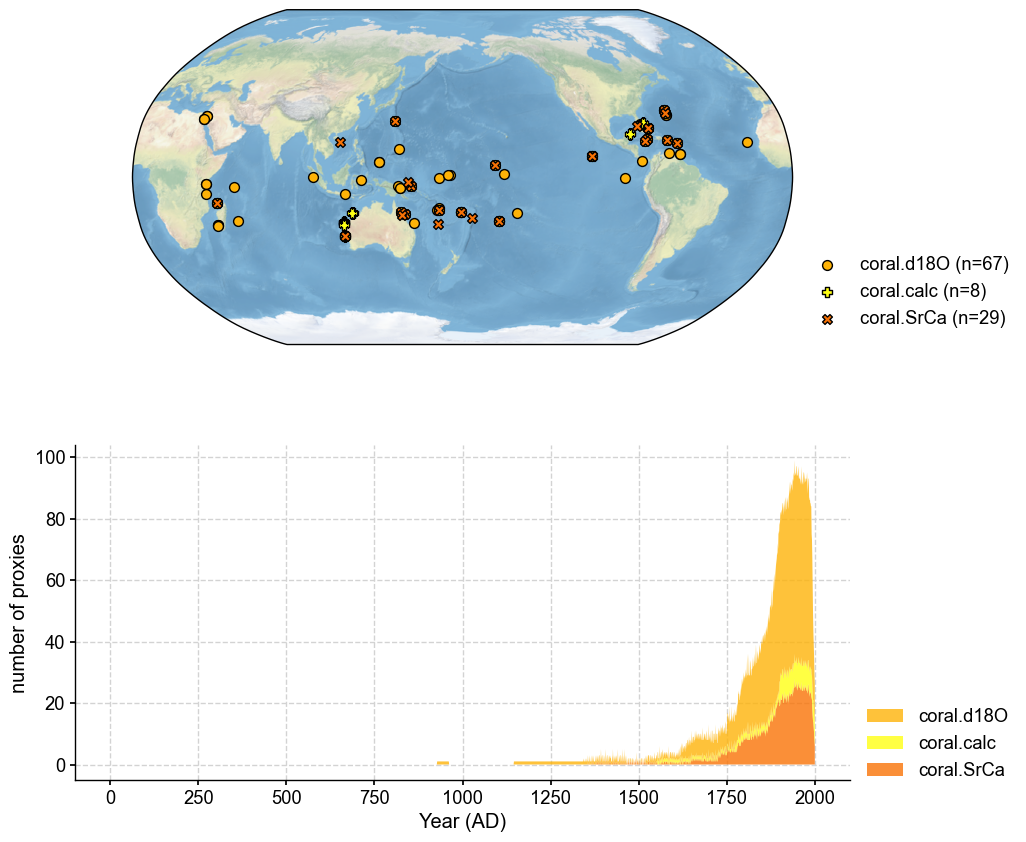

In [4]:
job.filter_proxydb(by='ptype', keys=['coral'])
# the .plot() method will generate a static map utilizing the Cartopy library
fig, ax = job.proxydb.plot(plot_count=True)

## Annualize/seasonalize the proxy database

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyRecord: 100%|██████████| 104/104 [00:05<00:00, 19.81it/s]


>>> 104 records remaining
>>> job.proxydb updated


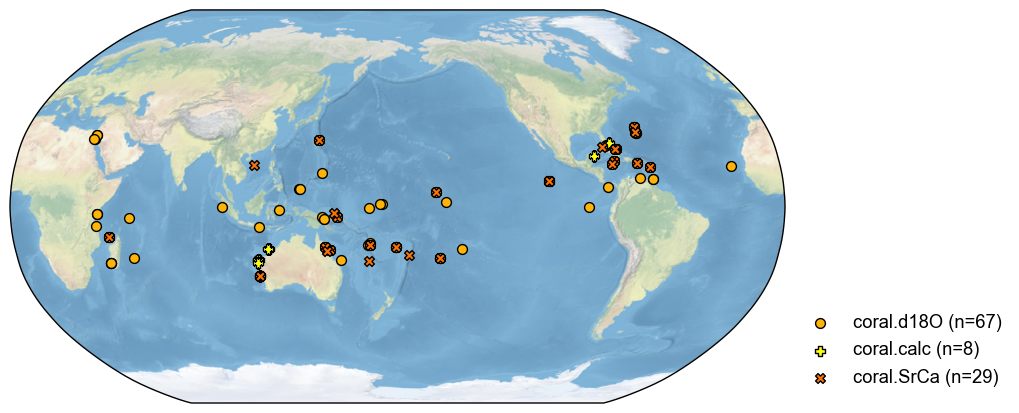

In [5]:
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)
fig, ax = job.proxydb.plot()

## Load climate model priors

In [6]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas'] loaded
>>> job.prior created


In [7]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/air.2m.mon.mean.nc',
    },
    rename_dict={'tas': 'air'},
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/air.2m.mon.mean.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'air'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


## Calibrate the PSMs

In [8]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.calc': 'Linear',
    'coral.SrCa': 'Linear',
}
ptype_season_dict = {
    'coral.d18O': [12, 1, 2],  # boreal winter
    'coral.calc': [12, 1, 2],  # boreal winter
    'coral.SrCa': [12, 1, 2],  # boreal winter
}
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    calib_period=(1901, 2000),
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'coral.SrCa': 'Linear', 'coral.d18O': 'Linear', 'coral.calc': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.SrCa': [12, 1, 2], 'coral.d18O': [12, 1, 2], 'coral.calc': [12, 1, 2]}
>>> job.configs["psm_calib_period"] = (1901, 2000)


Calibrating the PSMs:  15%|█▌        | 16/104 [00:00<00:04, 18.48it/s]

The number of overlapped data points is 7 < 25. Skipping ...
The number of overlapped data points is 16 < 25. Skipping ...


Calibrating the PSMs:  19%|█▉        | 20/104 [00:01<00:04, 18.34it/s]

The number of overlapped data points is 18 < 25. Skipping ...


Calibrating the PSMs:  27%|██▋       | 28/104 [00:01<00:04, 18.71it/s]

The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 24 < 25. Skipping ...
The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  52%|█████▏    | 54/104 [00:02<00:02, 18.59it/s]

The number of overlapped data points is 18 < 25. Skipping ...
The number of overlapped data points is 18 < 25. Skipping ...


Calibrating the PSMs:  58%|█████▊    | 60/104 [00:03<00:02, 18.75it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  75%|███████▌  | 78/104 [00:04<00:01, 18.84it/s]

The number of overlapped data points is 17 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 104/104 [00:05<00:00, 18.59it/s]

>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ocn_149 failed to be calibrated.
>>> PSM for Ocn_150 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_151 failed to be calibrated.
>>> PSM for Ocn_152 failed to be calibrated.
>>> PSM for Ocn_164 failed to be calibrated.
>>> PSM for Ocn_165 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ocn_183 failed to be calibrated.
>>> 94 records tagged "calibrated" with ProxyRecord.psm created


## Forward the PSMs

In [9]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]

>>> ProxyRecord.pseudo created for 94 records


## Annualize/seasonalize the climate model prior

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated


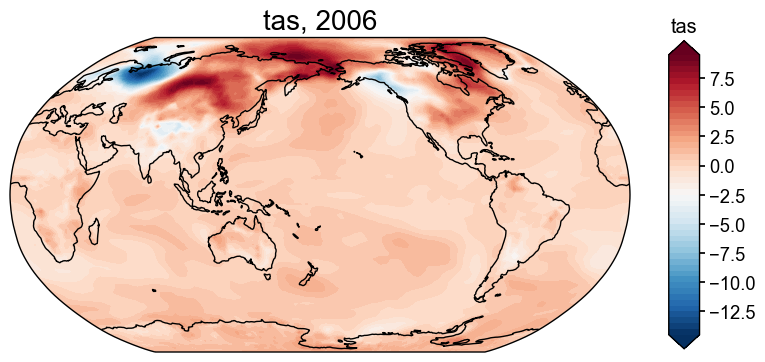

In [10]:
job.annualize_clim(tag='prior', verbose=True, months=[12, 1, 2])
fig, ax = job.prior['tas'][-1].plot()

## Regrid the prior field

In [11]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...


<xarray.DataArray 'tas' (time: 1157, lat: 42, lon: 63)>
array([[[-7.81051636e-01, -9.22830397e-01, -8.39860485e-01, ...,
         -8.08501951e-01, -7.90614220e-01, -7.81051636e-01],
        [-3.78635376e-01, -4.53974174e-01, -3.50083852e-01, ...,
         -1.68662978e-01, -2.71238134e-01, -3.78635376e-01],
        [-1.40333148e+00, -1.14323499e+00, -7.99864422e-01, ...,
         -1.24427407e+00, -1.01681555e+00, -1.40333148e+00],
        ...,
        [ 1.51642582e+00,  2.00791711e+00,  2.99710145e+00, ...,
         -4.22339864e-01,  6.26514400e-01,  1.51642582e+00],
        [ 1.51600985e+00,  1.81332871e+00,  1.98969666e+00, ...,
          7.17246048e-01,  1.15366462e+00,  1.51600985e+00],
        [-6.69174158e-02, -1.14359688e-01, -1.13317414e-01, ...,
         -8.39093201e-02, -6.26213337e-02, -6.69174158e-02]],

       [[ 3.99113983e-01,  2.50226913e-01,  3.51283409e-01, ...,
          3.76062861e-01,  3.98603538e-01,  3.99113983e-01],
        [ 8.05754848e-01,  7.93750219e-01,  9.23834707e-01, ...,
          8.62339883e-01,  8.53999842e-01,  8.05754848e-01],
        [ 3.78598088e-01,  6.81967098e-01,  9.79965517e-01, ...,
          3.73871145e-01,  7.06629183e-01,  3.78598088e-01],
...
        [-4.03990123e+00, -3.95388920e+00, -3.67437595e+00, ...,
         -2.82537085e+00, -3.68772147e+00, -4.03990123e+00],
        [-3.06803562e+00, -3.13736595e+00, -3.03790458e+00, ...,
         -2.70351666e+00, -2.89840592e+00, -3.06803562e+00],
        [-1.92743434e+00, -1.87511401e+00, -1.85468563e+00, ...,
         -1.97049589e+00, -1.95583223e+00, -1.92743434e+00]],

       [[ 1.40498352e+00,  1.38947419e+00,  1.34637156e+00, ...,
          1.34081884e+00,  1.37822305e+00,  1.40498352e+00],
        [ 1.24801511e+00,  1.29332777e+00,  1.29418854e+00, ...,
          1.12494411e+00,  1.31675206e+00,  1.24801511e+00],
        [ 6.13445684e-01,  5.69961440e-01,  4.73153888e-01, ...,
          1.13487406e+00,  9.78545336e-01,  6.13445684e-01],
        ...,
        [ 2.36734526e+00,  2.68027267e+00,  2.81354434e+00, ...,
          1.76056504e+00,  2.16766833e+00,  2.36734526e+00],
        [ 2.38290957e+00,  1.92326235e+00,  1.38590705e+00, ...,
          2.66820317e+00,  2.51788330e+00,  2.38290957e+00],
        [ 1.39060974e+00,  1.33488022e+00,  1.31009797e+00, ...,
          1.42522898e+00,  1.41616427e+00,  1.39060974e+00]]])
Coordinates:
  * time     (time) int64 850 851 852 853 854 855 ... 2002 2003 2004 2005 2006
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
Attributes:
    annualized:  1

## Crop the prior field

>>> job.configs["prior_lat_min"] = -35
>>> job.configs["prior_lat_max"] = 35
>>> job.configs["prior_lon_min"] = 0
>>> job.configs["prior_lon_max"] = 360
>>> Processing tas ...


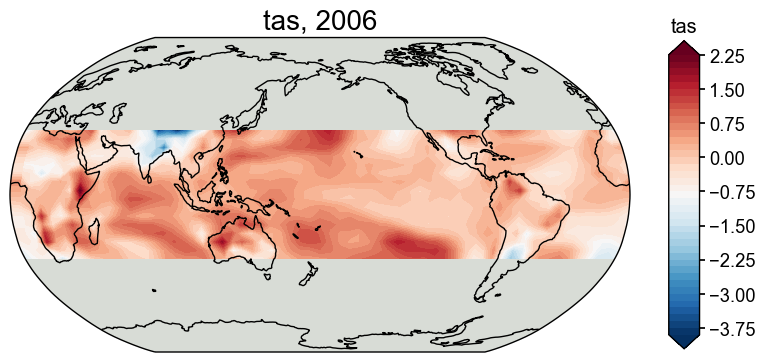

In [12]:
job.crop_clim(tag='prior', lat_min=-35, lat_max=35, verbose=True)
fig, ax = job.prior['tas'][-1].plot()

## Data assimilation

In [13]:
job.run_da_mc(
    save_dirpath='./recons/lmr-real-pages2k',
    recon_period=(1801, 2000),
    recon_seeds=list(range(1, 21)), verbose=True)

>>> job.configs["recon_period"] = (1801, 2000)
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr-real-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 2}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 20


KF updating: 100%|██████████| 200/200 [00:11<00:00, 16.80it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 20


KF updating: 100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r02_recon.nc
>>> seed: 3 | max: 20


KF updating: 100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r03_recon.nc
>>> seed: 4 | max: 20


KF updating: 100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r04_recon.nc
>>> seed: 5 | max: 20


KF updating: 100%|██████████| 200/200 [00:16<00:00, 11.96it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r05_recon.nc
>>> seed: 6 | max: 20


KF updating: 100%|██████████| 200/200 [00:16<00:00, 11.87it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r06_recon.nc
>>> seed: 7 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r07_recon.nc
>>> seed: 8 | max: 20


KF updating: 100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r08_recon.nc
>>> seed: 9 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r09_recon.nc
>>> seed: 10 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.23it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r10_recon.nc
>>> seed: 11 | max: 20


KF updating: 100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r11_recon.nc
>>> seed: 12 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r12_recon.nc
>>> seed: 13 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r13_recon.nc
>>> seed: 14 | max: 20


KF updating: 100%|██████████| 200/200 [00:18<00:00, 11.09it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r14_recon.nc
>>> seed: 15 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r15_recon.nc
>>> seed: 16 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.21it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r16_recon.nc
>>> seed: 17 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.12it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r17_recon.nc
>>> seed: 18 | max: 20


KF updating: 100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r18_recon.nc
>>> seed: 19 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r19_recon.nc
>>> seed: 20 | max: 20


KF updating: 100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r20_recon.nc
>>> DONE! Total time used: 5.97 mins.


## Validation

In [14]:
res = cfr.ReconRes('./recons/lmr-real-pages2k', verbose=True)

>>> res.paths:
['./recons/lmr-real-pages2k/job_r01_recon.nc', './recons/lmr-real-pages2k/job_r02_recon.nc', './recons/lmr-real-pages2k/job_r03_recon.nc', './recons/lmr-real-pages2k/job_r04_recon.nc', './recons/lmr-real-pages2k/job_r05_recon.nc', './recons/lmr-real-pages2k/job_r06_recon.nc', './recons/lmr-real-pages2k/job_r07_recon.nc', './recons/lmr-real-pages2k/job_r08_recon.nc', './recons/lmr-real-pages2k/job_r09_recon.nc', './recons/lmr-real-pages2k/job_r10_recon.nc', './recons/lmr-real-pages2k/job_r11_recon.nc', './recons/lmr-real-pages2k/job_r12_recon.nc', './recons/lmr-real-pages2k/job_r13_recon.nc', './recons/lmr-real-pages2k/job_r14_recon.nc', './recons/lmr-real-pages2k/job_r15_recon.nc', './recons/lmr-real-pages2k/job_r16_recon.nc', './recons/lmr-real-pages2k/job_r17_recon.nc', './recons/lmr-real-pages2k/job_r18_recon.nc', './recons/lmr-real-pages2k/job_r19_recon.nc', './recons/lmr-real-pages2k/job_r20_recon.nc']


In [15]:
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


In [16]:
import scipy.io as sio
import numpy as np

data = sio.loadmat('./data/BC09_NINO34.mat')
start_yr = 1874
end_yr = 2000
nyr = end_yr-start_yr+1
nino34 = np.zeros(nyr)
for i in range(nyr):
    nino34[i] = np.mean(data['nino34'][12+i*12:14+i*12])

ref_value = nino34
ref_time = np.arange(start_yr, end_yr+1)
ref_name = 'BC09'

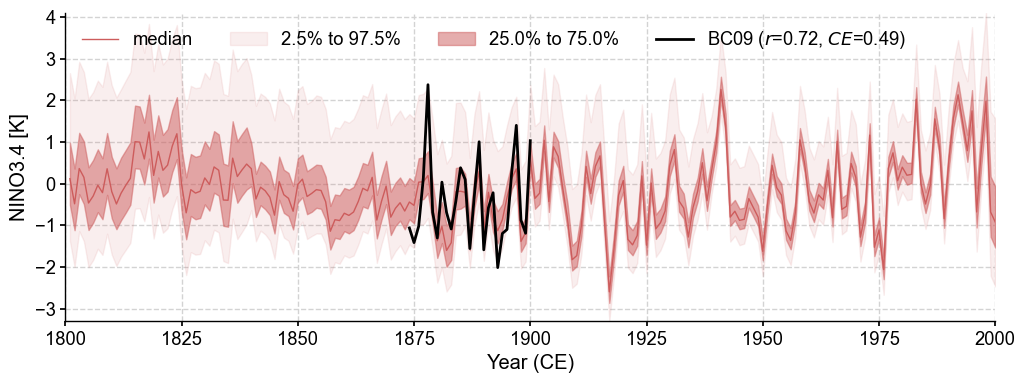

Figure saved at: "figs/valid_nino34.lmr_pages2k.20CR.pdf"


In [17]:
fig, ax = res.recons['nino3.4'].validate(
    ref_time, ref_value, ref_name, valid_period=(1874, 1900)).plot_qs()
ax.set_xlim(1800, 2000)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, './figs/valid_nino34.lmr_pages2k.20CR.pdf')

In [23]:
ref_fd_ann = job.obs['tas'].annualize(months=[12, 1, 2])

/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


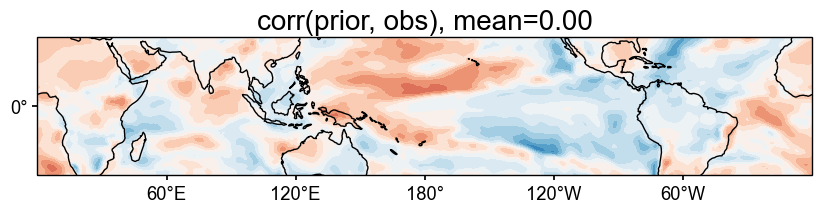

Figure saved at: "figs/valid_tas.iCESM.20CR.{stat}.pdf"


In [24]:
stat = 'corr'
valid_fd = job.prior['tas'].validate(
    ref_fd_ann, stat=stat,
    valid_period=(1874, 1900),
)

valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fd.plot(
    title=f'{stat}(prior, obs), mean={valid_fd.geo_mean().value[0][0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
)

cfr.showfig(fig)
cfr.savefig(fig, './figs/valid_tas.iCESM.20CR.{stat}.pdf')

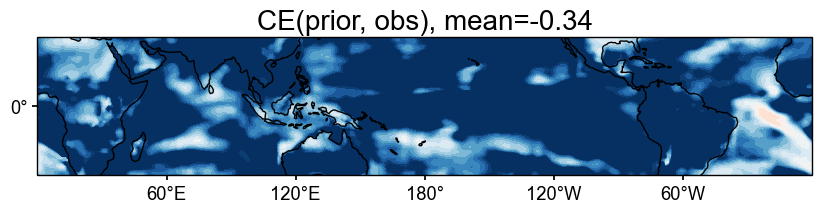

Figure saved at: "figs/valid_tas.iCESM.20CR.CE.pdf"


In [25]:
stat = 'CE'
valid_fd = job.prior['tas'].validate(
    ref_fd_ann, stat=stat,
    valid_period=(1874, 1900),
)

valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fd.plot(
    title=f'{stat}(prior, obs), mean={valid_fd.geo_mean().value[0][0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/valid_tas.iCESM.20CR.{stat}.pdf')

/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/fengzhu/conda-envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


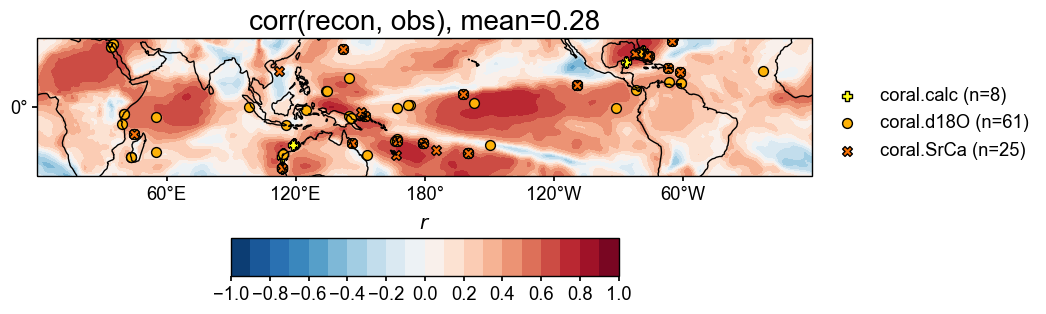

Figure saved at: "figs/valid_tas.lmr_pages2k.20CR.corr.pdf"


In [26]:
stat = 'corr'
valid_fd = res.recons['tas'].validate(
    ref_fd_ann, stat=stat,
    valid_period=(1874, 1900),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0][0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/valid_tas.lmr_pages2k.20CR.{stat}.pdf')

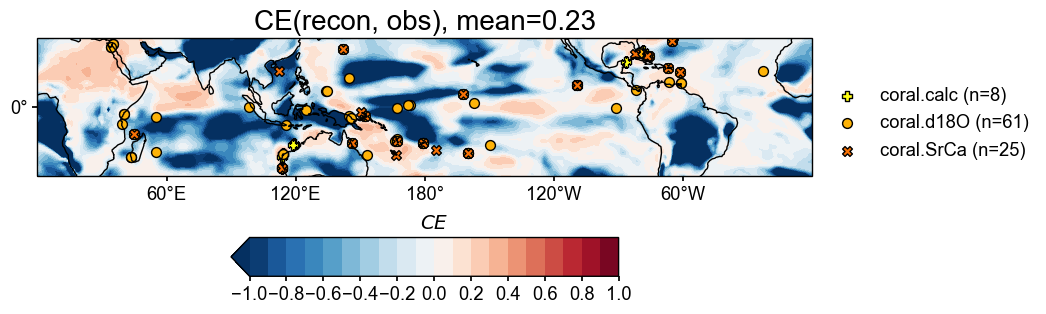

Figure saved at: "figs/valid_tas.lmr_pages2k.20CR.CE.pdf"


In [27]:
stat = 'CE'
valid_fd = res.recons['tas'].validate(
    ref_fd_ann, stat=stat,
    valid_period=(1874, 1900),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0][0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/valid_tas.lmr_pages2k.20CR.{stat}.pdf')